In [1]:
import sys
print(sys.version)

3.8.5 (default, Jul 21 2020, 10:48:26) 
[Clang 11.0.3 (clang-1103.0.32.62)]


https://coral.ai/docs/edgetpu/tflite-python/#inferencing-example

To download the required files see https://github.com/google-coral/tflite/blob/master/python/examples/classification/install_requirements.sh

In [2]:
# !pip freeze

# crucially pycoral==2.0.0

In [3]:
import os
import pathlib
import time

from pycoral.utils import edgetpu
from pycoral.utils import dataset

from pycoral.adapters import common
from pycoral.adapters import classify # classification
from pycoral.adapters import detect # obj det

from PIL import Image
from PIL import ImageDraw

## run a classification model

In [4]:
model_file = os.path.join('models', 'mobilenet_v2_1.0_224_inat_bird_quant_edgetpu.tflite')
# model_file = os.path.join('models', 'mobilenet_v2_1.0_224_inat_bird_quant.tflite')
print(os.path.isfile(model_file))

label_file = os.path.join('models', 'inat_bird_labels.txt')
print(os.path.isfile(label_file))

image_file = os.path.join('images', 'parrot.jpg')
print(os.path.isfile(image_file))

True
True
True


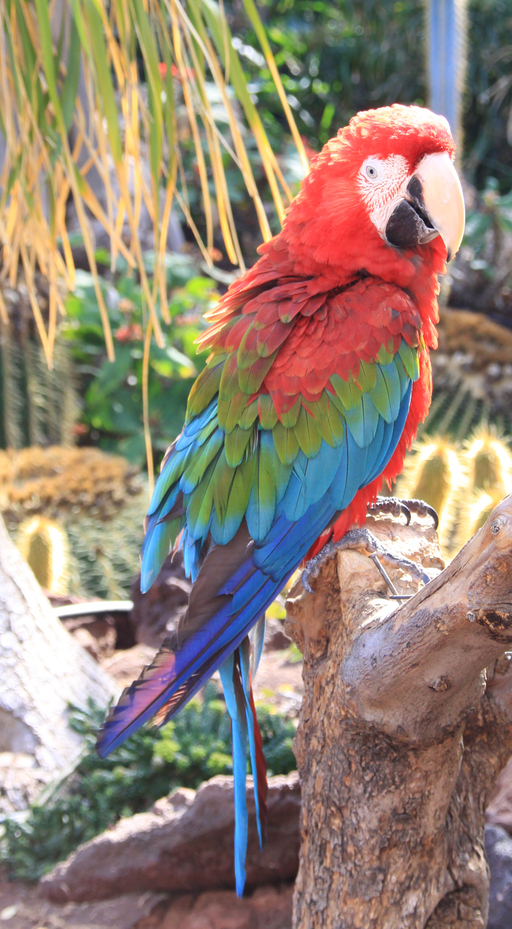

In [5]:
Image.open(image_file)

In [6]:
# Initialize the TF interpreter
interpreter = edgetpu.make_interpreter(model_file)
interpreter.allocate_tensors()

In [7]:
# Resize the image
size = common.input_size(interpreter)
image = Image.open(image_file).convert('RGB').resize(size, Image.ANTIALIAS)

# Run an inference
common.set_input(interpreter, image)
interpreter.invoke()
classes = classify.get_classes(interpreter, top_k=1)

# Print the result
labels = dataset.read_label_file(label_file)
for c in classes:
    print('%s: %.5f' % (labels.get(c.id, c.id), c.score))

Ara macao (Scarlet Macaw): 0.77734


## Obj detection example
https://github.com/google-coral/pycoral/blob/master/examples/detect_image.py

In [8]:
def draw_objects(draw, objs, labels):
  """Draws the bounding box and label for each object."""
  for obj in objs:
    bbox = obj.bbox
    draw.rectangle([(bbox.xmin, bbox.ymin), (bbox.xmax, bbox.ymax)],
                   outline='red')
    draw.text((bbox.xmin + 10, bbox.ymin + 10),
              '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
              fill='red')

In [9]:
model_file = os.path.join('models', 'ssd_mobilenet_v2_coco_quant_postprocess_edgetpu.tflite')
# model_file = os.path.join('models', 'mobilenet_v2_1.0_224_inat_bird_quant.tflite')
print(os.path.isfile(model_file))

label_file = os.path.join('models', 'coco_labels.txt')
print(os.path.isfile(label_file))

True
True


In [10]:
# Initialize the TF interpreter
interpreter = edgetpu.make_interpreter(model_file)
interpreter.allocate_tensors()

In [11]:
# Resize the image
size = common.input_size(interpreter)
image = Image.open(image_file)

_, scale = common.set_resized_input(
  interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

In [12]:
threshold = 0.4 # Score threshold for detected objects

start = time.perf_counter()
interpreter.invoke()
inference_time = time.perf_counter() - start
objs = detect.get_objects(interpreter, threshold, scale)
print('%.2f ms' % (inference_time * 1000))

33.00 ms


Anas platyrhynchos diazi (Mexican Duck)
  id:     15
  score:  0.984375
  bbox:   BBox(xmin=97, ymin=83, xmax=477, ymax=857)


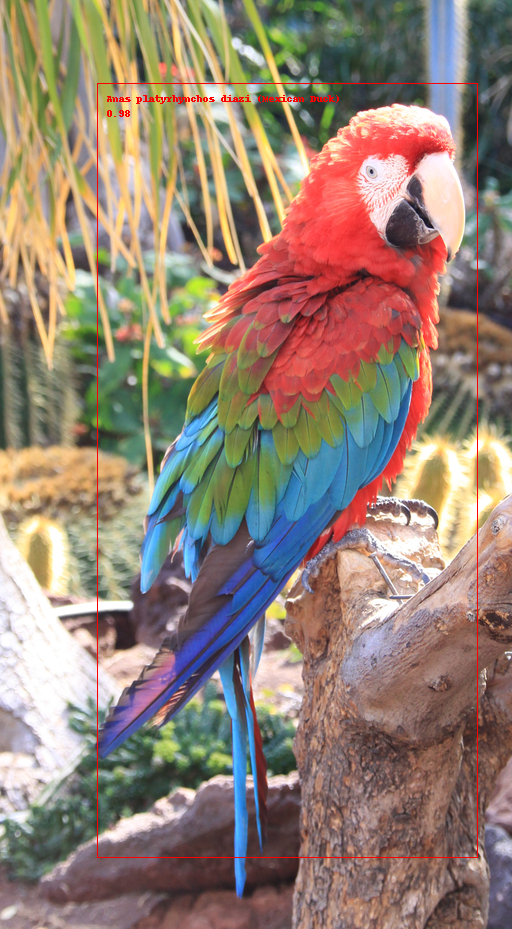

In [13]:
image = image.convert('RGB')

for obj in objs:
    print(labels.get(obj.id, obj.id))
    print('  id:    ', obj.id)
    print('  score: ', obj.score)
    print('  bbox:  ', obj.bbox)
    
    
    draw_objects(ImageDraw.Draw(image), objs, labels)

image